# Neuronale Netze: digits datset

Dieses Jupyter Notebook führt die Ergebnisse des dritten Projektes im Modul Special Engineering (M30) zum Thema Neuronale Netze auf. Als Datenset wird das digits Datenset verwendet.

In [1]:
###############################################################################
# Digits Dataset: Logistische Regression
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

from sklearn.datasets import load_digits

from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score

import time
import pandas as pd
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import activations

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping #, TensorBoard



#from scipy.stats.kde import gaussian_kde
from scipy.stats import kde, distributions
##########################
#import helperfunctions
import helper

%load_ext autoreload
%autoreload 2


In [2]:
tf.keras.__version__

'2.3.0-tf'

In [3]:
####################
# load datasets
####################
dataset = load_digits()
#print(dataset.DESCR, '\n', '\n')
X = dataset.data
y = dataset.target

targets = dataset.target_names
images = dataset.images



### Visualisieren von einzelnen Ziffern
Nachdem das Datenset geladen wurde, können vereinzelte Zahlen illustriert werden.

digit = 0 at index = 0


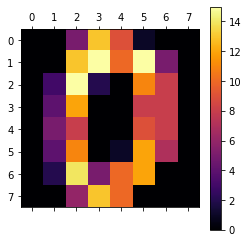

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]



digit = 0 at index = 20


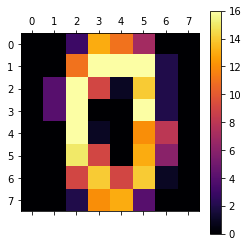

[[ 0.  0.  3. 13. 11.  7.  0.  0.]
 [ 0.  0. 11. 16. 16. 16.  2.  0.]
 [ 0.  4. 16.  9.  1. 14.  2.  0.]
 [ 0.  4. 16.  0.  0. 16.  2.  0.]
 [ 0.  0. 16.  1.  0. 12.  8.  0.]
 [ 0.  0. 15.  9.  0. 13.  6.  0.]
 [ 0.  0.  9. 14.  9. 14.  1.  0.]
 [ 0.  0.  2. 12. 13.  4.  0.  0.]]



digit = 8 at index = 500


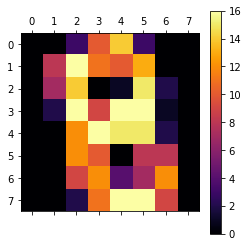

[[ 0.  0.  3. 10. 14.  3.  0.  0.]
 [ 0.  8. 16. 11. 10. 13.  0.  0.]
 [ 0.  7. 14.  0.  1. 15.  2.  0.]
 [ 0.  2. 16.  9. 16. 16.  1.  0.]
 [ 0.  0. 12. 16. 15. 15.  2.  0.]
 [ 0.  0. 12. 10.  0.  8.  8.  0.]
 [ 0.  0.  9. 12.  4.  7. 12.  0.]
 [ 0.  0.  2. 11. 16. 16.  9.  0.]]



digit = 8 at index = 508


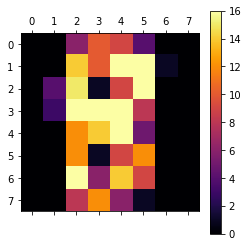

[[ 0.  0.  6. 10.  9.  4.  0.  0.]
 [ 0.  0. 14. 10. 16. 16.  1.  0.]
 [ 0.  4. 15.  1.  9. 16.  0.  0.]
 [ 0.  3. 16. 16. 16.  8.  0.  0.]
 [ 0.  0. 12. 14. 16.  5.  0.  0.]
 [ 0.  0. 12.  1.  9. 12.  0.  0.]
 [ 0.  0. 16.  6. 14.  9.  0.  0.]
 [ 0.  0.  8. 12.  6.  1.  0.  0.]]



digit = 5 at index = 1700


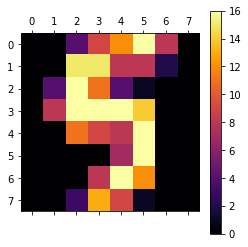

[[ 0.  0.  4.  9. 12. 16.  8.  0.]
 [ 0.  0. 15. 15.  8.  8.  2.  0.]
 [ 0.  4. 16. 11.  4.  1.  0.  0.]
 [ 0.  8. 16. 16. 16. 14.  0.  0.]
 [ 0.  0. 11.  9.  8. 16.  0.  0.]
 [ 0.  0.  0.  0.  7. 16.  0.  0.]
 [ 0.  0.  0.  8. 16. 12.  0.  0.]
 [ 0.  0.  3. 13.  9.  1.  0.  0.]]



digit = 5 at index = 1787


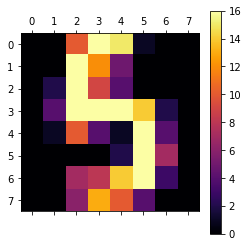

[[ 0.  0. 10. 16. 15.  1.  0.  0.]
 [ 0.  0. 16. 12.  5.  0.  0.  0.]
 [ 0.  2. 16.  9.  4.  0.  0.  0.]
 [ 0.  4. 16. 16. 16. 14.  2.  0.]
 [ 0.  1. 10.  4.  1. 16.  4.  0.]
 [ 0.  0.  0.  0.  2. 16.  7.  0.]
 [ 0.  0.  7.  8. 14. 16.  3.  0.]
 [ 0.  0.  6. 13. 10.  4.  0.  0.]]





In [15]:
for ind in [0,20,500,508,1700,1787]:
    print(f'digit = {y[ind]} at index = {ind}')
    plt.matshow(images[ind], cmap = cm.inferno)
    plt.colorbar()
    plt.show()
    print(f'{images[ind]}\n\n\n')

Zu sehen ist, dass die selben Ziffern häufig minimale Unterschiede untereinander haben. Die Zeilen 3 und 4 wirken stark frequentiert, hingegen die Spalten 0 und 7 sehr schwach.

Anzumerken ist noch, dass die Features des Datensets, aufgrund der Tatsache, dass es sich ausschlißelich um Helligkeitswerte handelt, bereits skaliert sind.
Ein erneutes skalieren ist somit nicht unbedingt Notwendig aber dennoch ratsam, da das Gradientenabstiegsverfahren wohl deutlich schneller Konvergiert.
https://en.wikipedia.org/wiki/Feature_scaling#cite_note-1

In [4]:
#scale to 0...1
X = X/16

Auffälig ist dennoch,wenn man sich den Mittelwert und die Standartabweichung der einzelnen Features anschaut, fällt nochmals auf, dass beide bei drei Features jeweils 0.0 ist, was eigentlich bedeuted, dass es zwischen den einzelnen digits bei diesen Features keine Unterschiede gibt, welche für Verhersagungen genutz werden können.
Somit könnten diese drei Features komplett ausgeschlossen werden um ggf. Prozessorzeit oder Speicher zu sparen.

Anschließend wird das Datenset in Trainingsdate, Testdaten und Validierungsdaten aufgeteilt.

In [5]:
####################
# split dataset (60:20:20)
####################


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

print('trainset ',np.shape(X_train),np.shape(y_train),
      '\ntestset ', np.shape(X_test),np.shape(y_test),
      '\nvalidationset ',np.shape(X_val),np.shape(y_val))

trainset  (1078, 64) (1078,) 
testset  (359, 64) (359,) 
validationset  (360, 64) (360,)


D:\Documents\Uni\!code\git\python\ann\helper.py:37: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax2.stem([0],[0.1], '-.')


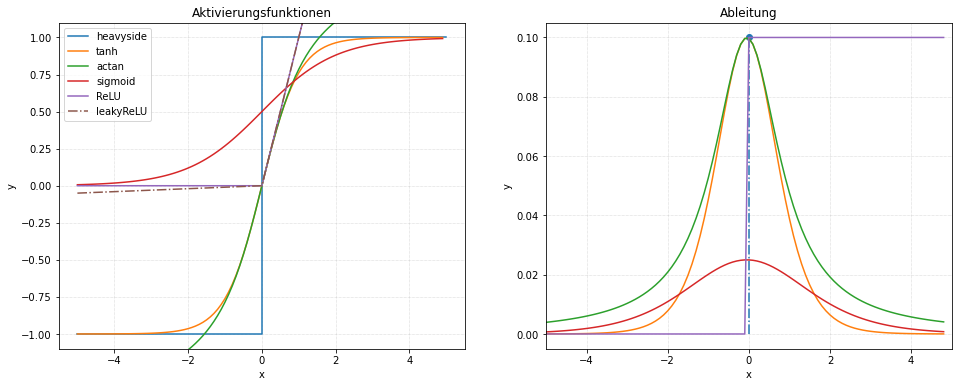

In [6]:

helper.plotactivationfunctions()


Lineare Aktivierungsfunktionen unterliegen einer starken Beschränkung, da eine Komposition linearer Funktionen durch arithmetische Umformungen durch eine einzige lineare Funktion dargestellt werden kann. Für mehrschichtige Verbindungsnetzwerke sind sie deswegen nicht geeignet und finden so nur in einfachen Modellen Anwendung. 

In [119]:
#https://keras.io/api/layers/regularizers/
#https://keras.io/api/layers/normalization_layers/batch_normalization/
#https://keras.io/api/layers/regularization_layers/dropout/
#https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
#https://keras.io/api/layers/regularization_layers/activity_regularization/
#https://keras.io/api/layers/core_layers/activation/

def create_model(n_hidden_layer=1, n_neurons_per_layer=32, learning_rate=5e-4, momentum=0.9, dropout=0.2, optimizer="SGD"):
    model = Sequential()
    #inputlayer
    model.add(layers.Dense(64, activation='relu', input_shape=(64,)))
    
    #hiddenlayer
    for lay in range(n_hidden_layer):
        model.add(layers.BatchNormalization(momentum=momentum))
        model.add(layers.Dropout(dropout))
        model.add(layers.Dense(n_neurons_per_layer, activation='relu', activity_regularizer=regularizers.l2(learning_rate)))
    
    #outpulayer
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=["accuracy"])

    
    return model


model_path = "!digit_classifier_{}.h5".format(time.time())
#model_path = "!digit_classifier_1572964918.600015.h5"

#learning_rate = 5e-3
nb_epoch = 1000
nb_batches = 100
#https://datascience.stackexchange.com/questions/12532/does-batch-size-in-keras-have-any-effects-in-results-quality



nb_batch_size = round(len(X_train) / nb_batches)


checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=0,
                               save_best_only=True)

early_stopping = EarlyStopping(patience=30,
                               verbose=0,
                               restore_best_weights=True)



In [26]:
model_sk = KerasClassifier(build_fn=create_model)

scorer = make_scorer(f1_score, average='weighted')


param_grid = {

    'n_hidden_layer': [3, 4, 5, 6],
    'n_neurons_per_layer': [180, 200, 220, 240, 260],
    'learning_rate': [5e-4],
    'momentum': [0.999],
    'dropout' : [0.1, 0.2, 0.3]
    #'patient' : [10, 30, 50, 70]
    #'n_jobs':[-1],
    #'random_state': [seed]
}

grid = GridSearchCV(estimator=model_sk,
                    param_grid=param_grid,
                    scoring=scorer,
                    verbose=2,
                    #n_jobs=-1,
                    cv=3)

grid_result = grid.fit(X_train, y_train, epochs=nb_epoch,
                    shuffle=True,
                    batch_size=nb_batch_size,
                    validation_data=(X_val, y_val),
                    verbose=0,
                    callbacks=[checkpointer, early_stopping])


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] dropout=0.1, learning_rate=0.0005, momentum=0.999, n_hidden_layer=3, n_neurons_per_layer=180 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
print(f'{grid.best_params_} with {grid.best_score_}')

In [120]:
best_params_ = {
    "dropout" : 0.2,
    "learning_rate": 0.0005,
    "momentum": 0.999,
    "n_hidden_layer": 4,
    "n_neurons_per_layer": 200 
}


In [121]:
bestmodel = create_model(**best_params_)
bestmodel.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_64 (Batc (None, 64)                256       
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 200)               13000     
_________________________________________________________________
batch_normalization_65 (Batc (None, 200)               800       
_________________________________________________________________
dropout_54 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 200)             

In [122]:
history = bestmodel.fit(X_train, y_train, epochs=nb_epoch,
                    shuffle=True,
                    batch_size=nb_batch_size,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[checkpointer, early_stopping])

Epoch 1/1000
98/98 [==============================] - 2s 17ms/step - loss: 2.4539 - accuracy: 0.2931 - val_loss: 2.2336 - val_accuracy: 0.3028
Epoch 2/1000
98/98 [==============================] - 1s 14ms/step - loss: 1.7247 - accuracy: 0.5575 - val_loss: 2.1599 - val_accuracy: 0.4444
Epoch 3/1000
98/98 [==============================] - 1s 14ms/step - loss: 1.4688 - accuracy: 0.6262 - val_loss: 2.0701 - val_accuracy: 0.2861
Epoch 4/1000
98/98 [==============================] - 1s 14ms/step - loss: 1.4525 - accuracy: 0.6252 - val_loss: 1.9786 - val_accuracy: 0.2556
Epoch 5/1000
98/98 [==============================] - 1s 13ms/step - loss: 1.3140 - accuracy: 0.7078 - val_loss: 1.8879 - val_accuracy: 0.2972
Epoch 6/1000
98/98 [==============================] - 1s 13ms/step - loss: 1.2370 - accuracy: 0.7328 - val_loss: 1.8173 - val_accuracy: 0.2472
Epoch 7/1000
98/98 [==============================] - 1s 14ms/step - loss: 1.3006 - accuracy: 0.7078 - val_loss: 1.7552 - val_accuracy: 0.2750

Epoch 58/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.8062 - accuracy: 0.8609 - val_loss: 0.3425 - val_accuracy: 0.9806
Epoch 59/1000
98/98 [==============================] - 2s 19ms/step - loss: 0.7795 - accuracy: 0.8571 - val_loss: 0.3404 - val_accuracy: 0.9778
Epoch 60/1000
98/98 [==============================] - 2s 20ms/step - loss: 0.7883 - accuracy: 0.8599 - val_loss: 0.3303 - val_accuracy: 0.9833
Epoch 61/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.8028 - accuracy: 0.8534 - val_loss: 0.3507 - val_accuracy: 0.9750
Epoch 62/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.7067 - accuracy: 0.8887 - val_loss: 0.3256 - val_accuracy: 0.9833
Epoch 63/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.7109 - accuracy: 0.8859 - val_loss: 0.3406 - val_accuracy: 0.9806
Epoch 64/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.7676 - accuracy: 0.8590 - val_loss: 0.3375 - val_accuracy:

Epoch 115/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.6222 - accuracy: 0.9035 - val_loss: 0.3133 - val_accuracy: 0.9528
Epoch 116/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5486 - accuracy: 0.9202 - val_loss: 0.2929 - val_accuracy: 0.9806
Epoch 117/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.5690 - accuracy: 0.9045 - val_loss: 0.3005 - val_accuracy: 0.9694
Epoch 118/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.6070 - accuracy: 0.9017 - val_loss: 0.2886 - val_accuracy: 0.9778
Epoch 119/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5766 - accuracy: 0.9007 - val_loss: 0.2905 - val_accuracy: 0.9750
Epoch 120/1000
98/98 [==============================] - 2s 16ms/step - loss: 0.5662 - accuracy: 0.9054 - val_loss: 0.2828 - val_accuracy: 0.9861
Epoch 121/1000
98/98 [==============================] - 2s 16ms/step - loss: 0.6035 - accuracy: 0.8980 - val_loss: 0.2877 - val_ac

98/98 [==============================] - 1s 14ms/step - loss: 0.5191 - accuracy: 0.9082 - val_loss: 0.2703 - val_accuracy: 0.9722
Epoch 172/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5364 - accuracy: 0.9007 - val_loss: 0.2611 - val_accuracy: 0.9833
Epoch 173/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5021 - accuracy: 0.9193 - val_loss: 0.2506 - val_accuracy: 0.9833
Epoch 174/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.5666 - accuracy: 0.9035 - val_loss: 0.2613 - val_accuracy: 0.9833
Epoch 175/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.5376 - accuracy: 0.9100 - val_loss: 0.2506 - val_accuracy: 0.9806
Epoch 176/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5199 - accuracy: 0.9035 - val_loss: 0.2489 - val_accuracy: 0.9833
Epoch 177/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5303 - accuracy: 0.9100 - val_loss: 0.2586 - val_accuracy: 0.9806


98/98 [==============================] - 1s 13ms/step - loss: 0.4744 - accuracy: 0.9156 - val_loss: 0.2537 - val_accuracy: 0.9722
Epoch 228/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.4952 - accuracy: 0.9026 - val_loss: 0.2556 - val_accuracy: 0.9722
Epoch 229/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.4484 - accuracy: 0.9276 - val_loss: 0.2521 - val_accuracy: 0.9722
Epoch 230/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.5195 - accuracy: 0.9017 - val_loss: 0.2272 - val_accuracy: 0.9833
Epoch 231/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.4828 - accuracy: 0.9147 - val_loss: 0.2256 - val_accuracy: 0.9861
Epoch 232/1000
98/98 [==============================] - 2s 16ms/step - loss: 0.4706 - accuracy: 0.9221 - val_loss: 0.2147 - val_accuracy: 0.9833
Epoch 233/1000
98/98 [==============================] - 1s 15ms/step - loss: 0.5085 - accuracy: 0.9156 - val_loss: 0.2200 - val_accuracy: 0.9833


98/98 [==============================] - 1s 14ms/step - loss: 0.4130 - accuracy: 0.9323 - val_loss: 0.2136 - val_accuracy: 0.9833
Epoch 284/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.4238 - accuracy: 0.9332 - val_loss: 0.2159 - val_accuracy: 0.9806
Epoch 285/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.3931 - accuracy: 0.9249 - val_loss: 0.2101 - val_accuracy: 0.9833
Epoch 286/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.4171 - accuracy: 0.9193 - val_loss: 0.2176 - val_accuracy: 0.9750
Epoch 287/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.4536 - accuracy: 0.9156 - val_loss: 0.2175 - val_accuracy: 0.9722
Epoch 288/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.4407 - accuracy: 0.9249 - val_loss: 0.2286 - val_accuracy: 0.9722
Epoch 289/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.4162 - accuracy: 0.9314 - val_loss: 0.2079 - val_accuracy: 0.9861


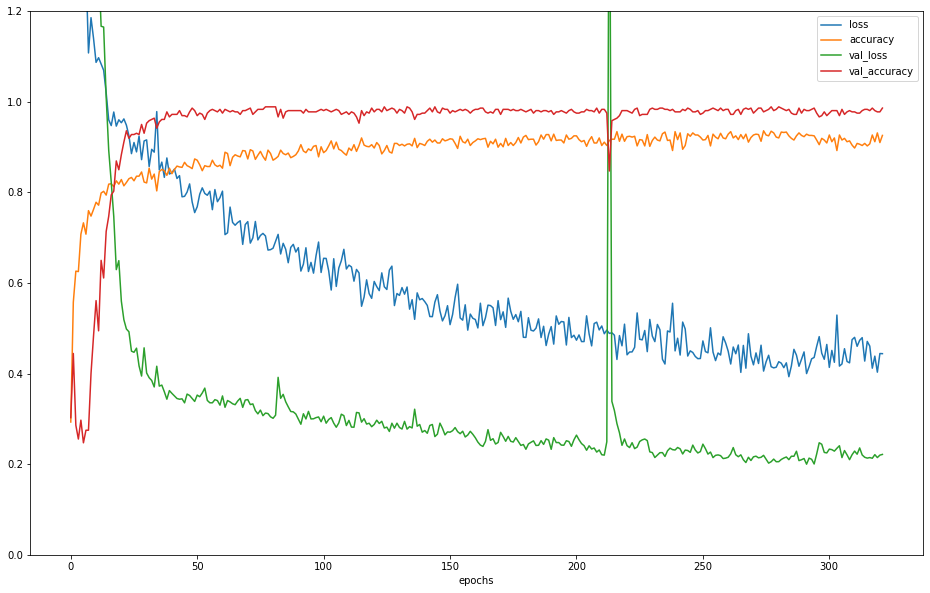

In [123]:
fig = plt.figure(figsize=(16,10))
df = pd.DataFrame(history.history)
plt.ylim(0,1.2)
plt.xlabel('epochs')
plt.plot(df)
plt.legend(df.columns)
plt.show()

In [124]:
predictions = bestmodel.predict(X_test)

y_pred = np.zeros(np.shape(y_test))

In [125]:
for ind, pred in enumerate(predictions):
    y_pred[ind] = np.argmax(pred)

In [126]:
cnf_matrix = confusion_matrix(y_test,y_pred)

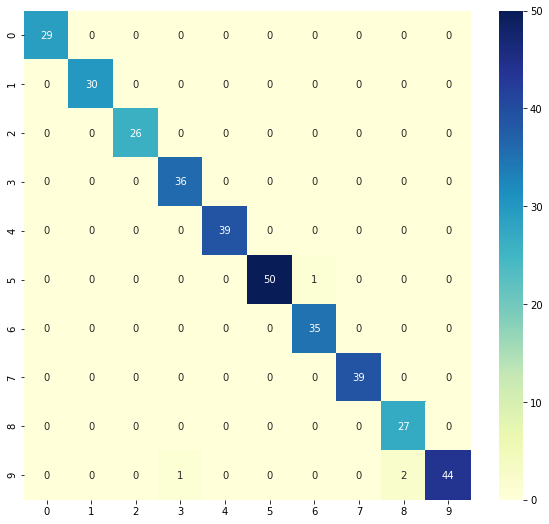

In [127]:
fig = plt.figure(figsize=(10,9))
sns.heatmap(cnf_matrix, cmap='YlGnBu', annot=True)
plt.show()

In [128]:
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        26
           3       0.97      1.00      0.99        36
           4       1.00      1.00      1.00        39
           5       1.00      0.98      0.99        51
           6       0.97      1.00      0.99        35
           7       1.00      1.00      1.00        39
           8       0.93      1.00      0.96        27
           9       1.00      0.94      0.97        47

    accuracy                           0.99       359
   macro avg       0.99      0.99      0.99       359
weighted avg       0.99      0.99      0.99       359



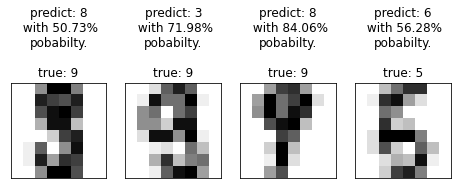

In [129]:
# Plot
f = plt.figure(figsize=(12, 12))
ind  =0
mask = y_test != y_pred

for i, d in enumerate(X_test):
    if mask[i]:
        #print(i, y_test[i],y_pred[i])
        img = d.reshape(8,8)
        sub = f.add_subplot(3, 6, ind+1)
        sub.imshow(img, cmap=plt.cm.gray_r)
        plt.xticks([])
        plt.yticks([])
        sub.set_title(f'predict: {int(y_pred[i])}\n with {np.max(predictions[i]*100):.4}%\npobabilty.\n\ntrue: {y_test[i]}')
        ind=ind+1